In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import glob
import os
import tables as tb
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
import sys
import pickle
import time
import re

In [3]:
gen_area = 1069156 # in square cm

CanfrancFlux=5.8*10**-7 #muons/cm2/s
CanfrancFluxYear=CanfrancFlux*gen_area *31536000 #muons/year (using crosssectional area of simulation surface)

SnolabFlux=.27*10**-4/(24*60*60) #muons/cm2/s

GranSassoFlux=3.432e-8 #muons/cm2/s
GranSassoFluxErr=.003e-8

SURFFlux=4.4*10**-9 #muons/cm2/s
SURFFluxErr=.25e-9



GranSassoFluxYear=GranSassoFlux*gen_area *31536000 #correct
massofxeindetect=1109 #kg
enrich=.903 #90.3

In [4]:
clrs= ['darkmagenta','deepskyblue','violet','mediumpurple',"rebeccapurple"]
palette = plt.get_cmap('tab10')

In [5]:
locat = '/users/rogerslc/Google Drive/He3Studies/'

acti_file = locat+'Xe137Count_sim87799000muons.h5'
muonnrgsproducingXe137=pd.read_hdf(acti_file)

flux_file = locat+"/cosmo_flux/lngs_100Mmuons.h5"
file_out = locat+"/cosmo_flux/lngs_xe137.h5"

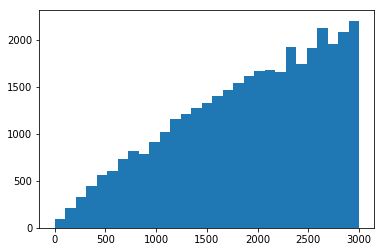

In [6]:
#binning settings
low_lim=1 #GeV
high_lim=3000 #GeV
stp_size=100

numberofmuons=87799000

bins=np.linspace(low_lim,high_lim,30)



bin_centers = bins[:-1] + np.diff(bins) / 2


nrgs=np.random.uniform(low_lim,high_lim,numberofmuons)
binned_sim_muons, _ =np.histogram(nrgs,bins=bins)
binned_Xe137data=plt.hist(muonnrgsproducingXe137['Xemunrg']*10**-3,bins)


xe137_df = pd.read_hdf(acti_file)
xe137_df['GeV'] = xe137_df.Xemunrg * 1e-3

xe137_count, _ = np.histogram(xe137_df.GeV.values, bins = bins)
xe137_exp = xe137_count / binned_sim_muons
xe137_exp_err  = xe137_exp * np.sqrt(1 / xe137_count + 1 / numberofmuons)

In [7]:
lab_flux=GranSassoFlux
lab_flux_e = GranSassoFluxErr

## Get flux in the same bins
for i in range(10):

    vals = pd.read_hdf(flux_file, 'muon_flux_'+str(i))

    histo, _ = np.histogram(vals.E.values, bins = bins)

    try:
        flux_histo0 += histo
    except NameError:
        flux_histo0  = histo

norm_flux = flux_histo0 / flux_histo0.sum()
flux_err  = norm_flux * np.sqrt(1 / flux_histo0 + 1 / flux_histo0.sum())
fluxCMS   = norm_flux * lab_flux
fluxCMS_e = fluxCMS * np.sqrt((flux_err / norm_flux)**2+ (lab_flux_e / lab_flux)**2)
fluxS     = fluxCMS * gen_area
fluxS_e   = gen_area * fluxCMS_e
xe137S    = xe137_exp * fluxS ## Xe137 per bin per second
xe137S_e  = xe137S * np.sqrt((xe137_exp_err / xe137_exp)**2 + (fluxS_e / fluxS)**2)                              
xe137Y    = xe137S * 3.1536e7
xe137Y_e  = xe137S_e * 3.1536e7


total_xe137PS = xe137S.sum()
perSec_err    = np.sqrt(np.sum(xe137S_e**2))
total_xe137PY = xe137Y.sum()
perYr_err     = np.sqrt(np.sum(xe137Y_e**2))

In [8]:
#to compare with measure snolab flux and see if proportionality is same

flux_file = locat+"/cosmo_flux/snolab_100Mmuons.h5"

lab_flux=SnolabFlux
lab_flux_e = GranSassoFluxErr

## Get flux in the same bins
for i in range(10):

    vals = pd.read_hdf(flux_file, 'muon_flux_'+str(i))

    histo, _ = np.histogram(vals.E.values, bins = bins)

    try:
        flux_histo += histo
    except NameError:
        flux_histo  = histo

norm_fluxSno = flux_histo / flux_histo.sum()
flux_errSno  = norm_fluxSno * np.sqrt(1 / flux_histo + 1 / flux_histo.sum())
fluxCMS   = norm_flux * lab_flux
fluxCMS_e = fluxCMS * np.sqrt((flux_err / norm_flux)**2+ (lab_flux_e / lab_flux)**2)
fluxS     = fluxCMS * gen_area
fluxS_e   = gen_area * fluxCMS_e

In [9]:
color = 'magma'

# colormax should be the number of colors you'll be sampling from
# n is which color you want to sample 
bar = plt.get_cmap(color)
def get_color(n, colormax=5.0):
    #0,1,2,3,
    colorVal = bar(n/(colormax-1))
    return(colorVal) # (r, g, b)

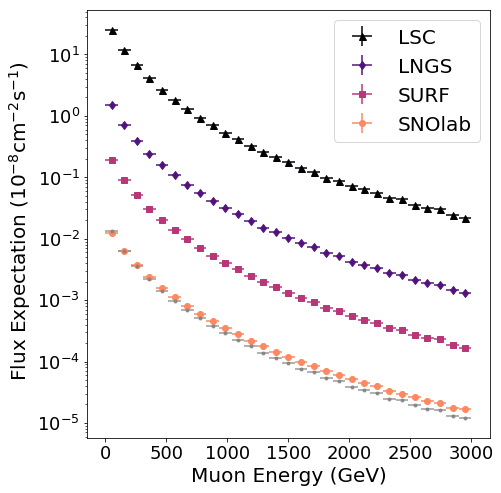

In [10]:
plt.figure(figsize=(7,7))

plt.xlabel('Muon Energy (GeV)',fontsize=20)
plt.ylabel(' Flux Expectation (10$^{-8}$cm$^{-2}$s$^{-1}$)',fontsize=20)
plt.yticks(fontsize=18) 
plt.xticks(fontsize=18)

#plt.ylim(0,.75)
plt.tight_layout()
plt.semilogy()



plt.errorbar(bin_centers, (norm_flux*CanfrancFlux*10**8 ), fmt='^', ms=7,
                 xerr = np.diff(bins) / 2, yerr = flux_err*CanfrancFlux*10**8,label="LSC",color=get_color(0))

plt.errorbar(bin_centers, (norm_flux*GranSassoFlux*10**8 ), fmt='d',
                 xerr = np.diff(bins) / 2, yerr = flux_err*GranSassoFlux*10**8,label="LNGS",color=get_color(1))

plt.errorbar(bin_centers, (norm_flux*SURFFlux*10**8 ), fmt='s',
                 xerr = np.diff(bins) / 2, yerr = flux_err*SURFFlux*10**8,label="SURF",color=get_color(2))

plt.errorbar(bin_centers, (norm_fluxSno*SnolabFlux*10**8 ), fmt='o',
                 xerr = np.diff(bins) / 2, yerr = flux_errSno*SnolabFlux*10**8,label="SNOlab",color=get_color(3))

plt.errorbar(bin_centers, (norm_flux*SnolabFlux*10**8 ), fmt='.',
                 xerr = np.diff(bins) / 2, yerr = flux_err*SnolabFlux*10**8,color="gray",alpha=.8)




#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(fontsize=20, loc="upper right")
#plt.savefig("MuonFluxes.png",dpi=250,bbox_inches='tight')
plt.show()

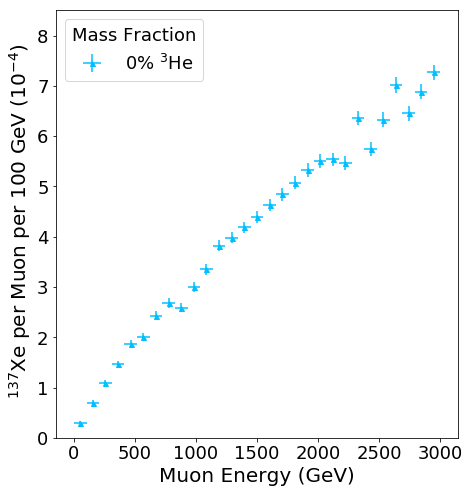

In [307]:
plt.figure(figsize=(7,7))


plt.xlabel('Muon Energy (GeV)',fontsize=20)
plt.ylabel(' $^{137}$Xe per Muon per '+str(stp_size)+ ' GeV (10$^{-4}$)',fontsize=20)
plt.yticks(fontsize=18) 
plt.xticks(fontsize=18)

plt.tight_layout()
#plt.semilogy()
plt.ylim(0,8.5)
#plt.bar(bin_centers,(binned_Xe137data[0]/binned_sim_muons),width=stp_size,color="deepskyblue",label="0% Helium")    
plt.errorbar(bin_centers, (binned_Xe137data[0]/binned_sim_muons*10**4 ), fmt='^',
                 xerr = np.diff(bins) / 2, yerr = xe137_exp_err*10**4,color="deepskyblue",label="0% $^{3}$He",ms=5) 
             
             
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(fontsize=18, loc="upper left", title="Mass Fraction",title_fontsize=18)
plt.savefig("xepermuenerg.png",dpi=250,bbox_inches='tight')
#plt.savefig("xepermuenerg.pdf")
plt.show()


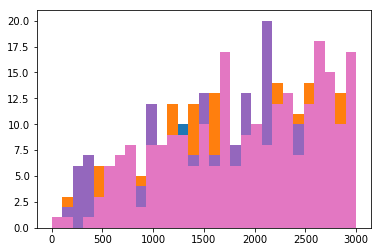

In [12]:
#0.1% of He3 data
locatpt1='/Users/rogerslc/Google Drive/He3Studies/MuonDatapt1percHe3/'
pt1data='He3Xe137datacombinedfrom6960000_99.9.h5'
pt1data_e='He3Xe137datacombinedfrom4429000_99.9.h5'
pt1data_d='He3Xe137datacombinedfrom7217750_99.9.h5'
pt1data_a='He3Xe137datacombinedfrom8038000_99.9.h5'
pt1data_c='He3Xe137datacombinedfrom1766000_99.9.h5'
pt1data_b='He3Xe137datacombinedfrom1076000_99.9.h5'
pt1data_f='He3Xe137datacombinedfrom9283000_99.9.h5'

numberofmuonsHe3pt1=6960000+4429000+7217750+3101000+1076000+1766000+9283000
#numberofmuonsHe3pt1=3101000


acti_filept1 = locatpt1+pt1data
muonnrgsproducingXe137withHe3pt1=pd.read_hdf(acti_filept1)
hist1=plt.hist(muonnrgsproducingXe137withHe3pt1['Xemunrg']*10**-3,bins)[0]
acti_filept1a = locatpt1+pt1data_a
muonnrgsproducingXe137withHe3pt1a=pd.read_hdf(acti_filept1a)
hist1a=plt.hist(muonnrgsproducingXe137withHe3pt1a['Xemunrg']*10**-3,bins)[0]
acti_filept1b = locatpt1+pt1data_b
muonnrgsproducingXe137withHe3pt1b=pd.read_hdf(acti_filept1b)
hist1b=plt.hist(muonnrgsproducingXe137withHe3pt1b['Xemunrg']*10**-3,bins)[0]
acti_filept1c = locatpt1+pt1data_c
muonnrgsproducingXe137withHe3pt1c=pd.read_hdf(acti_filept1c)
hist1c=plt.hist(muonnrgsproducingXe137withHe3pt1c['Xemunrg']*10**-3,bins)[0]
acti_filept1d = locatpt1+pt1data_d
muonnrgsproducingXe137withHe3pt1d=pd.read_hdf(acti_filept1d)
hist1d=plt.hist(muonnrgsproducingXe137withHe3pt1d['Xemunrg']*10**-3,bins)[0]
acti_filept1e = locatpt1+pt1data_e
muonnrgsproducingXe137withHe3pt1e=pd.read_hdf(acti_filept1e)
hist1e=plt.hist(muonnrgsproducingXe137withHe3pt1e['Xemunrg']*10**-3,bins)[0]
acti_filept1f = locatpt1+pt1data_f
muonnrgsproducingXe137withHe3pt1f=pd.read_hdf(acti_filept1e)
hist1f=plt.hist(muonnrgsproducingXe137withHe3pt1f['Xemunrg']*10**-3,bins)[0]

nrgspt1=np.random.uniform(low_lim,high_lim,numberofmuonsHe3pt1)
binned_sim_muonsHe3pt1, _ =np.histogram(nrgspt1,bins=bins)

#binned_Xe137dataHe3pt1=plt.hist(muonnrgsproducingXe137withHe3pt1['Xemunrg']*10**-3,bins)[0]
binned_Xe137dataHe3pt1=hist1a+hist1b+hist1c+hist1d+hist1e+hist1+hist1f



xe137_expHe3pt1 = binned_Xe137dataHe3pt1 / binned_sim_muonsHe3pt1
xe137_exp_errHe3pt1  = np.sqrt(1 / binned_Xe137dataHe3pt1)

xe137Y_eHe3pt1=xe137_expHe3pt1*norm_flux*GranSassoFluxYear
xe137Y_eHe3errpt1=xe137_exp_errHe3pt1/ binned_sim_muonsHe3pt1*norm_flux*GranSassoFluxYear

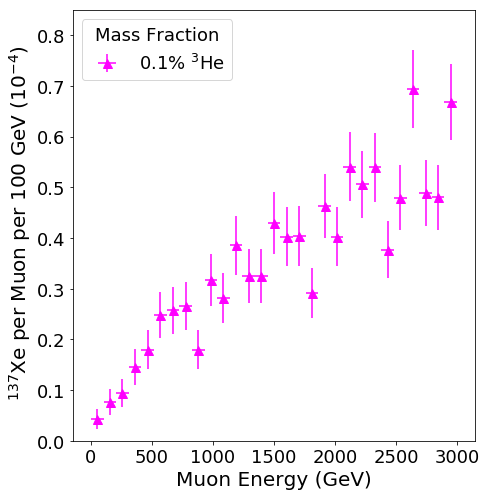

In [309]:
plt.figure(figsize=(7,7))

plt.xlabel('Muon Energy (GeV)',fontsize=20)
plt.ylabel(' $^{137}$Xe per Muon per '+str(stp_size)+ ' GeV (10$^{-4}$)',fontsize=20)
plt.yticks(fontsize=18) 
plt.xticks(fontsize=18)

plt.ylim(0,.85)
plt.tight_layout()

#plt.errorbar(bin_centers, (binned_Xe137data[0]/binned_sim_muons*10**4 ), fmt='^',
                 #xerr = np.diff(bins) / 2, yerr = xe137_exp_err*10**4,color="deepskyblue",label="0% $^{3}$He",ms=5) 
             

plt.errorbar(bin_centers, (binned_Xe137dataHe3pt1/binned_sim_muonsHe3pt1*10**4 ), fmt='^',
                 xerr = np.diff(bins) / 2, yerr = xe137_exp_errHe3pt1*binned_Xe137dataHe3pt1/binned_sim_muonsHe3pt1*10**4,color="fuchsia",label="0.1% $^{3}$He",ms=9)     
    
#plt.errorbar(bin_centers, (binned_Xe137dataHe3[0]/binned_sim_muonsHe3*10**4 ), fmt='^',
#                 xerr = np.diff(bins) / 2, yerr = xe137_exp_errHe3*10**4,color="mediumpurple",label="1.0% $^{3}$He",ms=9)


             
plt.legend(fontsize=18, loc="upper left", title="Mass Fraction",title_fontsize=18)             
plt.savefig("xepermuenergHe3.png",dpi=250,bbox_inches='tight')
#plt.savefig("xepermuenergHe3.pdf")
plt.show()

6.683151774376797e-05 0.000726866587452189 7.567179269829552e-06 1.5493521100329075e-05


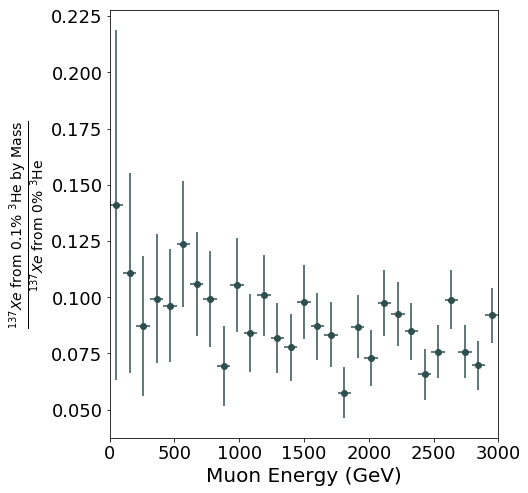

In [14]:
#ratio
yvals=[]
yeeer=[]
plt.figure(figsize=(7,7))

plt.xlabel('Muon Energy (GeV)',fontsize=20)
plt.ylabel(r"$\frac{^{137}Xe \mathrm{ \ from \ 0.1 \% \ ^{3}He \ by \ Mass}}{^{137}Xe \mathrm{ \ from \ 0\% \ ^{3}He}}$",fontsize=20)
plt.yticks(fontsize=18) 
plt.xticks(fontsize=18)

#plt.ylim(0,.75)
plt.tight_layout()


for pp in range(0,len(binned_Xe137dataHe3pt1)):
    A=(binned_Xe137dataHe3pt1[pp]/binned_sim_muonsHe3pt1[pp])
    B=(binned_Xe137data[0][pp]/binned_sim_muons[pp])
    sigA=xe137_exp_errHe3pt1[pp]*xe137_expHe3pt1[pp]
    sigB=xe137_exp_err[pp]
    yvals.append(A/B)
    yeeer.append(A/B*(sigA/A+sigB/B))
    
print (A,B,sigA, sigB)
    
plt.errorbar(bin_centers, yvals, fmt='o', 
                 xerr = np.diff(bins) / 2, yerr = yeeer,color="darkslategrey",label="0.1% He3")


#plt.axhline(y=.08, linestyle='--',color="darkslategrey")


plt.xlim(0,3000)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.legend(fontsize=20, loc="upper left")
#plt.savefig("xepermuratio.png",dpi=250,bbox_inches='tight')
#plt.savefig("xepermuratio.pdf")
plt.show()

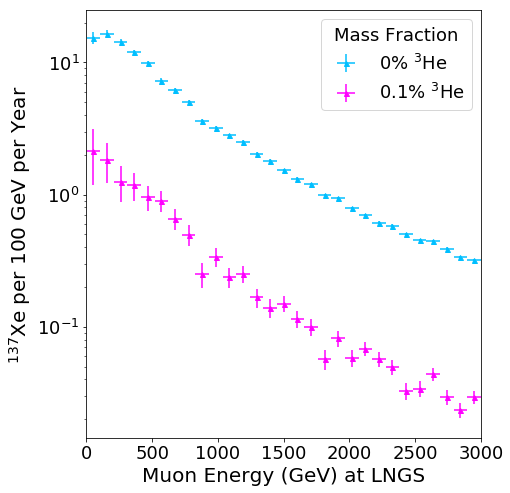

In [15]:
plt.figure(figsize=(7,7))

plt.xlabel('Muon Energy (GeV) at LNGS',fontsize=20)
plt.ylabel('$^{137}$Xe per 100 GeV per Year ',fontsize=20)
plt.yticks(fontsize=18) 
plt.xticks(fontsize=18)

plt.xlim(0,3000)
plt.tight_layout()
plt.semilogy()

plt.errorbar(bin_centers, (binned_Xe137data[0]/binned_sim_muons*norm_flux*GranSassoFluxYear ), fmt='^',
                 xerr = np.diff(bins) / 2, yerr = xe137Y_e,color="deepskyblue",label="0% $^{3}$He",ms=5)

plt.errorbar(bin_centers, (binned_Xe137dataHe3pt1/binned_sim_muonsHe3pt1*norm_flux*GranSassoFluxYear ), fmt='^',
                 xerr = np.diff(bins) / 2, yerr = xe137Y_eHe3errpt1*binned_Xe137dataHe3pt1 ,color="magenta",label="0.1% $^{3}$He",ms=5)

#plt.errorbar(bin_centerspt2, (binned_Xe137dataHe3pt2[0]/binned_sim_muonsHe3pt2*normfluxpt2*GranSassoFluxYear ), fmt='^',
                 #xerr = np.diff(binspt2) / 2, yerr = xe137Y_eHe3pt2,color="orange",label="0.2% $^{3}$He")

#plt.errorbar(bin_centers, (binned_Xe137dataHe3[0]/binned_sim_muonsHe3*norm_flux*GranSassoFluxYear ), fmt='^',
                 #xerr = np.diff(bins) / 2, yerr = binned_Xe137dataHe3[0]*xe137Y_eHe3,color="mediumpurple",label="1% $^{3}$He",ms=5)

#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(fontsize=18, loc="upper right", title="Mass Fraction",title_fontsize=18)
#plt.savefig("xepermuenerg_normalized.pdf")
#plt.savefig("xepermuenerg_normalized.png",dpi=250,bbox_inches='tight')
plt.show()

In [16]:
locat = '/users/rogerslc/Google Drive/He3Studies/'
numofXeHe4=[]
numofXeHe3=[]
PercentsofHe=[]
PercentsofHe4=[]
normalizednumofXeHe3=[]
normalizednumofXeHe4=[]



for files in glob.iglob(locat+'percofHeliums/Xe137_counts_sim1000000muons_f0-100_*He4.h5'):
    lengh=pd.read_hdf(files)    
    result = re.search('muons_f0-100_(.*)He4.h5', files)
    perc=result.group(1)
    if int(perc)==100:
        PercentsofHe.append(100-float(perc))
        numofXeHe3.append(len(lengh))
        normalizednumofXeHe3.append(len(lengh)/(massofxeindetect*(float(perc))/100*enrich)/1000000)        
    PercentsofHe4.append(100-float(perc))
    numofXeHe4.append(len(lengh))
    normalizednumofXeHe4.append(len(lengh)/(massofxeindetect*(float(perc))/100*enrich)/1000000)  
    
    
for files in glob.iglob(locat+'percofHeliums/He3Xe137datacombinedfrom1000000_*.h5'):
    lengh=pd.read_hdf(files)    
    result = re.search('combinedfrom1000000_(.*).h5', files)
    perc=result.group(1)
    PercentsofHe.append(100-float(perc))
    numofXeHe3.append(len(lengh))
    normalizednumofXeHe3.append( len(lengh)/(massofxeindetect*(float(perc))/100*enrich) /1000000 )
    
fastPercentsofHe=[]
fastnumofXeHe3=[]
fastnormalizednumofXeHe3=[]
fastPercentsofHe.append(PercentsofHe[0])
fastnumofXeHe3.append(numofXeHe3[0])
fastnormalizednumofXeHe3.append(normalizednumofXeHe3[0])

for files in glob.iglob(locat+'FastNeutronPercsHe3/Xe137_counts_sim*neutrons_f0-100_*He3E10000000.h5'):
    
    lengh=pd.read_hdf(files)    
    result = re.search('f0-100_(.*)He3E10000000.h5', files)
    fastperc=result.group(1)
    fastPercentsofHe.append(100-float(fastperc))
    fastnumofXeHe3.append(len(lengh))
    nsgnrd=(re.search('Xe137_counts_sim(.*)neutrons_f0', files)).group(1)
    #print (fastnumofXeHe3)
    fastnormalizednumofXeHe3.append(len(lengh)/(massofxeindetect*(float(fastperc))/100*enrich)/int(nsgnrd))    

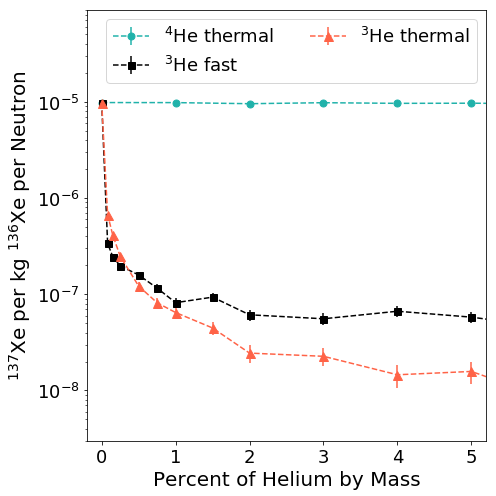

In [328]:
fasterrr3=[]
errr3=[]
errr4=[]


for t in range(0 , len(numofXeHe4)):
    errr4.append(normalizednumofXeHe4[t] * np.sqrt(1 / numofXeHe4[t]))

for p in range(0 , len(numofXeHe3)):
    errr3.append(normalizednumofXeHe3[p] * np.sqrt(1 / numofXeHe3[p]))


for r in range(0 , len(fastnumofXeHe3)):
    fasterrr3.append(fastnormalizednumofXeHe3[r] * np.sqrt(1 / fastnumofXeHe3[r]))    
    
    
    
plt.figure(figsize=(7,7))
#plt.bar(PercentsofHe,NumofXeforPercs)

PercentsofHe4s, normalizednumofXeHe4s,errr4s=zip(*sorted(zip(PercentsofHe4,normalizednumofXeHe4,errr4)))
fastPercentsofHes,fastnormalizednumofXeHe3s,fasterrr3s=zip(*sorted(zip(fastPercentsofHe,fastnormalizednumofXeHe3,fasterrr3)))
PercentsofHes,normalizednumofXeHe3s,errr3s=zip(*sorted(zip(PercentsofHe,normalizednumofXeHe3,errr3)))

plt.errorbar(PercentsofHe4s,normalizednumofXeHe4s, color="lightseagreen", yerr=errr4s,fmt='o',label="$^{4}$He thermal", ms=7, ls='--')
plt.errorbar(fastPercentsofHes,fastnormalizednumofXeHe3s, color="k", yerr=fasterrr3s,fmt='s',label="$^{3}$He fast",ms=7, ls='--')
plt.errorbar(PercentsofHes,normalizednumofXeHe3s, color="tomato", yerr=errr3s,fmt='^',label="$^{3}$He thermal",ms=9, ls='--')

#vars=np.arange(1,10,0.01)
#plt.plot(vars,6e-8/(vars))
#plt.plot(vars,15e-8/(vars))


#plt.axvline(x=.005)
plt.semilogy()
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
plt.xlim(-.2,5.2) 
#plt.xlim(-.01,.4) 

plt.ylim(3e-9,9e-5)  
plt.ylabel("$^{137}$Xe per kg $^{136}$Xe per Neutron",fontsize=20)
plt.yticks(fontsize=18) 
plt.xlabel('Percent of Helium by Mass',fontsize=20)
plt.tight_layout()
plt.legend(fontsize=18,loc=1,ncol=2)
#plt.savefig('normalizedHeliums.pdf')
plt.savefig("fastnormalizedHeliums.png",dpi=250,bbox_inches='tight')
plt.show()

In [300]:
locat2='/Users/rogerslc/Google Drive/He3Studies/Xe137fromdiffNRGS/'
locatpt1='/Users/rogerslc/Google Drive/He3Studies/MuonDatapt1percHe3/'

numofXe0He=[numofXeHe3[0]]
numofXe1He=[numofXeHe3[2]]
nrgsof0He=[10*10**-6]
nrgsof1He=[10*10**-6]
normalizednumofXe0He=[normalizednumofXeHe3[0]]
normalizednumofXe1He=[normalizednumofXeHe3[2]]
numofXept1He=[(numofXeHe3[3]+numofXeHe3[16])/2]
nrgsofpt1He=[10*10**-6]
normalizednumofXept1He=[normalizednumofXeHe3[3]]


for files in glob.iglob(locat2+'Xe137_counts_sim1000000muons_f0-100_100He3E*.h5'):
    lengh=pd.read_hdf(files)    
    result = re.search('muons_f0-100_100He3E(.*).h5', files)
    nrg=result.group(1)
    nrgsof0He.append(float(nrg)*10**-6)
    numofXe0He.append(len(lengh))
    normalizednumofXe0He.append(len(lengh)/(massofxeindetect*(100/100*enrich))/1000000)
    
    
for files in glob.iglob(locat2+'Xe137_counts_sim1000000muons_f0-100_99He3E*.h5'):
    lengh=pd.read_hdf(files)    
    result = re.search('muons_f0-100_99He3E(.*).h5', files)
    nrg=result.group(1)
    nrgsof1He.append(float(nrg)*10**-6)
    numofXe1He.append(len(lengh))
    normalizednumofXe1He.append(len(lengh)/(massofxeindetect*(99/100*enrich))/1000000) 
    
    
for files in glob.iglob(locatpt1+'Xe137_counts_sim*muons_f0-100_99.9He3E1*.h5'):
    #print (files)
    lengh=pd.read_hdf(files)    
    #print (lengh)
    result = re.search('muons_f0-100_99.9He3E(.*).h5', files)
    nrg=result.group(1)
    nrgsofpt1He.append(float(nrg)*10**-6)
    numofXept1He.append(len(lengh))
    nsgnrd=(re.search('Xe137_counts_sim(.*)muons_f0', files)).group(1)
    normalizednumofXept1He.append(len(lengh)/(massofxeindetect*(99.9/100*enrich))/int(nsgnrd)) 

In [122]:
nrgsofpt1He

[9.999999999999999e-06,
 100.0,
 0.001,
 9.999999999999999e-05,
 0.09999999999999999,
 0.01,
 10.0,
 1.0]

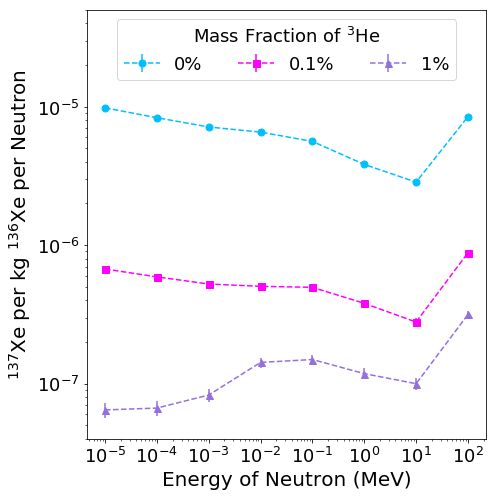

In [305]:
errr3=[]
errr3pt1=[]
errr4=[]


for t in range(0 , len(normalizednumofXe0He)):
    errr4.append(normalizednumofXe0He[t] * np.sqrt(1 / numofXe0He[t]))

for p in range(0 , len(normalizednumofXe1He)):
    errr3.append(normalizednumofXe1He[p] * np.sqrt(1 / numofXe1He[p]))
    
for r in range(0 , len(normalizednumofXept1He)):
    errr3pt1.append(normalizednumofXept1He[r] * np.sqrt(1 / numofXept1He[r]))
    
plt.figure(figsize=(7,7))


nrgsof0Hes, normalizednumofXe0Hes,errr4s=zip(*sorted(zip(nrgsof0He,normalizednumofXe0He,errr4)))
nrgsofpt1Hes, normalizednumofXept1Hes,errr3pt1s=zip(*sorted(zip(nrgsofpt1He,normalizednumofXept1He,errr3pt1)))
nrgsof1Hes, normalizednumofXe1Hes,errr3s=zip(*sorted(zip(nrgsof1He,normalizednumofXe1He,errr3)))

plt.errorbar(nrgsof0Hes,normalizednumofXe0Hes, color="deepskyblue", yerr=errr4s,fmt='o',label="0%",ms=7,ls='--')
plt.errorbar(nrgsofpt1Hes,normalizednumofXept1Hes, color="fuchsia", yerr=errr3pt1s,fmt='s',label="0.1%",ms=7,ls='--')
plt.errorbar(nrgsof1Hes,normalizednumofXe1Hes, color="mediumpurple", yerr=errr3s,fmt='^',label="1%",ms=7,ls='--')


plt.semilogx()
plt.semilogy()
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
plt.ylim(4*10**-8,5*10**-5)  
plt.ylabel("$^{137}$Xe per kg $^{136}$Xe per Neutron",fontsize=20)
plt.xlabel('Energy of Neutron (MeV)',fontsize=20)
plt.tight_layout()
plt.legend(fontsize=18,loc="upper center", ncol=3, title="Mass Fraction of $^{3}$He",title_fontsize=18)
plt.savefig('Helium3nrgs.png',dpi=250,bbox_inches='tight')
plt.show()

In [20]:
#to update these numbers have to change out flux etc up above and read out what they are
GranSasYr=[3.3,113.52,3.87,11.7] 
SnoLabYr=[6,1.03,.04,.107] 
CanFraYr=[2.2, 1918.54,65.32,198.4]  
SURFYr=[4.31,14.55,.50,1.51] 

purexe=[1918.54,113.52,1.03]
oneper=[38.44,3.865,.04]

Xlables=["LSC\n(2.2 km.w.e)", "LNGS\n(3.3 km.w.e)","SURF\n(4.3 km.w.e)","SNOlab\n(6 km.w.e)"]
xplace=[1.2,2.4,3.6,4.8]

[]

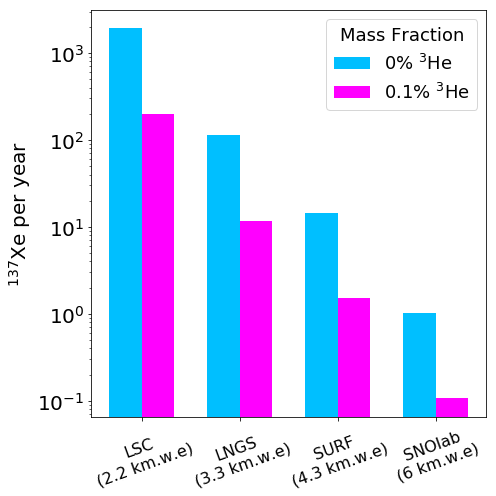

In [21]:
fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111)
ax1.bar(1,height=CanFraYr[1], width=.4,color="deepskyblue")
ax1.bar(2.2,height=GranSasYr[1], width=.4,color="deepskyblue",label="0% $^{3}$He")
ax1.bar(3.4,height=SURFYr[1], width=.4,color="deepskyblue")
ax1.bar(4.6,height=SnoLabYr[1], width=.4,color="deepskyblue")

ax1.bar(1.4,height=CanFraYr[3], width=.4,color="fuchsia")
ax1.bar(2.6,height=GranSasYr[3], width=.4,color="fuchsia",label="0.1% $^{3}$He")
ax1.bar(3.8,height=SURFYr[3], width=.4,color="fuchsia")
ax1.bar(5,height=SnoLabYr[3], width=.4,color="fuchsia")


'''ax1.bar(1.6,height=CanFraYr[2], width=.3, color="mediumpurple")
ax1.bar(2.8,height=GranSasYr[2], width=.3, color="mediumpurple",label="1% $^{3}$He")
ax1.bar(4,height=SURFYr[2], width=.3, color="mediumpurple")
ax1.bar(5.2,height=SnoLabYr[2], width=.3, color="mediumpurple")
'''
ax1.set_ylabel("$^{137}$Xe per year",fontsize=20)
plt.legend(fontsize=18,loc=1, title="Mass Fraction",title_fontsize=18)
plt.yticks(fontsize=20)
plt.xticks(xplace,Xlables,fontsize=16,rotation=20)
plt.semilogy()
plt.tight_layout()


plt.yticks(fontsize=20) 
plt.semilogy()
#plt.tight_layout()

#plt.savefig("difflabs.png",dpi=250,bbox_inches='tight')

In [265]:
#geant 4 cross checks
andlocat= '/Users/rogerslc/CylindricalXeData/'
andrews10e6=[]
andrews10=[]
andhighnumofXe=[]
andlownumofXe=[]
geantv105thermal=[]
geantv105fast=[]
errr105therm=[]
errr105fast=[]

geantspercs=[.1,.2,1.5]
andrews10e6.append(len(pd.read_hdf(andlocat+'Xe137datacombinedfrom1000000_99.9E10000000.h5'))/((massofxeindetect*(99.9)/100*enrich))/1000000)
andhighnumofXe.append(len(pd.read_hdf(andlocat+'Xe137datacombinedfrom1000000_99.9E10000000.h5')))
andrews10e6.append(len(pd.read_hdf(andlocat+'Xe137datacombinedfrom1000000_99.8E10000000.h5'))/((massofxeindetect*(99.8)/100*enrich))/1000000)
andhighnumofXe.append(len(pd.read_hdf(andlocat+'Xe137datacombinedfrom1000000_99.8E10000000.h5')))
andrews10e6.append(len(pd.read_hdf(andlocat+'Xe137datacombinedfrom1000000_98.5E10000000.h5'))/((massofxeindetect*(98.5)/100*enrich))/1000000)
andhighnumofXe.append(len(pd.read_hdf(andlocat+'Xe137datacombinedfrom1000000_98.5E10000000.h5')))

andrews10.append(len(pd.read_hdf(andlocat+'Xe137datacombinedfrom1000000_99.9E1e-06.h5'))/((massofxeindetect*(99.9)/100*enrich))/1000000)
andlownumofXe.append(len(pd.read_hdf(andlocat+'Xe137datacombinedfrom1000000_99.9E1e-06.h5')))
andrews10.append(len(pd.read_hdf(andlocat+'Xe137datacombinedfrom1000000_99.8E1e-06.h5'))/((massofxeindetect*(99.8)/100*enrich))/1000000)
andlownumofXe.append(len(pd.read_hdf(andlocat+'Xe137datacombinedfrom1000000_99.8E1e-06.h5')))
andrews10.append(len(pd.read_hdf(andlocat+'Xe137datacombinedfrom1000000_98.5E1e-06.h5'))/((massofxeindetect*(98.5)/100*enrich))/1000000)
andlownumofXe.append(len(pd.read_hdf(andlocat+'Xe137datacombinedfrom1000000_98.5E1e-06.h5')))


geantv105thermal.append(normalizednumofXept1He[0])
errr105therm.append(errr3pt1s[0])

g4105therm=len(pd.read_hdf(andlocat+'oldXe137datacombinedfrom1000000_99.8E1e-06.h5'))
geantv105thermal.append(g4105therm/((massofxeindetect*(99.8)/100*enrich))/1000000)
errr105therm.append(geantv105thermal[1]*np.sqrt(1 / g4105therm))

geantv105thermal.append(normalizednumofXeHe3s[7])
errr105therm.append(normalizednumofXeHe3[7] * np.sqrt(1 / numofXeHe3[7]))



geantv105fast.append(normalizednumofXept1He[7])
errr105fast.append(errr3pt1s[7])

g4105fast=len(pd.read_hdf(andlocat+'oldXe137datacombinedfrom1000000_99.8E10000000.h5'))
geantv105fast.append(g4105fast/((massofxeindetect*(99.8)/100*enrich))/1000000)
errr105fast.append(geantv105fast[1]*np.sqrt(1 / g4105fast))

geantv105fast.append(fastnormalizednumofXeHe3s[7])
errr105fast.append((fastnormalizednumofXeHe3[7] * np.sqrt(1 / fastnumofXeHe3[7])))

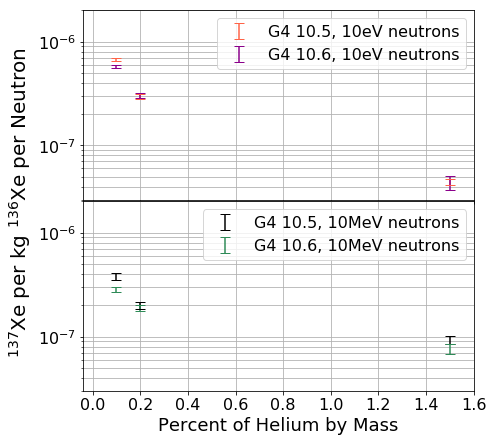

In [325]:
fasterrr3=[]
errr3=[]
errr4=[]
andlowerrr3=[]
andhigherrr3=[]
  

for s in range(0 , len(andrews10)):
    andlowerrr3.append(andrews10[s] * np.sqrt(1 / andlownumofXe[s]))  

for w in range(0 , len(andrews10e6)):
    andhigherrr3.append(andrews10e6[w] * np.sqrt(1 / andhighnumofXe[w]))  



ax = fig.add_subplot(111)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,sharey=True,figsize=(7,7))
plt.subplots_adjust(hspace=0.01)


ax1 = plt.subplot(211)
plt.semilogy()
plt.yticks(fontsize=16)  
plt.xticks(fontsize=16) 
plt.grid(True, which="both")
plt.errorbar(geantspercs,geantv105thermal,fmt='none' , color="tomato", yerr=errr105therm,label="G4 10.5, 10eV neutrons", capsize=5)
plt.errorbar(geantspercs,andrews10, color="darkmagenta", fmt='none', yerr=andlowerrr3,label="G4 10.6, 10eV neutrons", capsize=5)
plt.setp(ax1.get_xticklabels(),visible=False)
plt.legend(fontsize=16,loc=1)

plt.xlim(-.04,1.6)
plt.ylim(3e-8,2e-6) 

ax2 = plt.subplot(212)
plt.semilogy()
plt.grid(True, which="both")
plt.yticks(fontsize=16)  
plt.xticks(fontsize=16) 
plt.errorbar(geantspercs,geantv105fast,fmt='none' , color="k", yerr=errr105fast,label="G4 10.5, 10MeV neutrons", capsize=5)
plt.errorbar(geantspercs,andrews10e6, color="seagreen", fmt='none', yerr=andhigherrr3,label="G4 10.6, 10MeV neutrons", capsize=5)

#ax.set_ylabel("$^{137}$Xe per kg $^{136}$Xe per neutron",fontsize=20)
fig.text(0, 0.5, "$^{137}$Xe per kg $^{136}$Xe per Neutron",fontsize=20, ha='center', va='center', rotation='vertical')
plt.xlabel('Percent of Helium by Mass',fontsize=18)
#plt.ylabel("$^{137}$Xe per kg $^{136}$Xe per neutron",fontsize=20)

plt.xlim(-.04,1.6) 
plt.ylim(3e-8,2e-6)  

#plt.tight_layout()
plt.legend(fontsize=16,loc=1)
plt.savefig("geant4check.png",dpi=250,bbox_inches='tight')
plt.show()

In [323]:
a=geantv105fast[0]
b=andrews10e6[0]
stda=errr105fast[0]
stdb=andlowerrr3[0]

print(a/b,"+/_",a/b*(stda/a+stdb/b))
print(geantv105thermal[0]/andrews10[0],"+/_")

1.3286713286713285 +/_ 0.21972911473418674
1.1681689101281028 +/_


In [296]:
#from endf database

n2n=pd.read_csv(locat+'n2ncrosssection.csv',engine='python',header=None)
n3n=pd.read_csv(locat+'n3ncrosssectionR2.csv',engine='python',header=None)
xe136cross=pd.read_csv(locat+'xe136toxe137crosssectionR2.csv',engine='python',header=None)
xe136elastcross=pd.read_csv(locat+'elasticscattering.csv',engine='python',header=None)
He3ncross=pd.read_csv(locat+'He3CrossSections.csv',engine='python',header=None)
Cu63n2n=pd.read_csv(locat+'Cu63_n2n_crosssection.csv',engine='python',header=None)
Cu65n2n=pd.read_csv(locat+'Cu65_n2n_crosssection.csv',engine='python',header=None)
Cu65n3n=pd.read_csv(locat+'Cu65_n3n_crosssection.csv',engine='python',header=None)

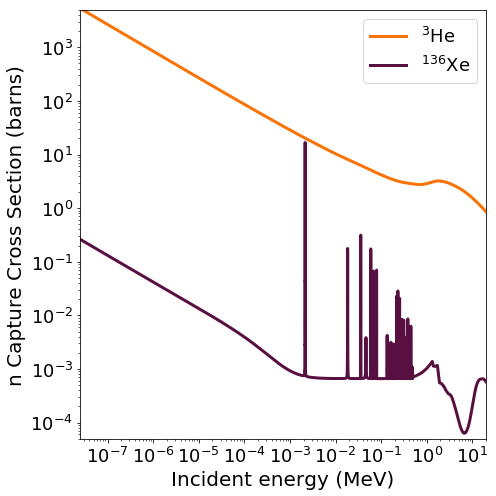

In [297]:
plt.figure(figsize=(7,7))
plt.plot(He3ncross[0],He3ncross[1],label="$^{3}$He",color='xkcd:orange',lw=3)
plt.plot(xe136cross[0],xe136cross[1],label="$^{136}$Xe",color='xkcd:plum',lw=3)


plt.semilogx()
plt.semilogy()
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
plt.ylim(5e-5,5000)  
plt.xlim(25e-9,20)
plt.ylabel("n Capture Cross Section (barns)",fontsize=20)
plt.xlabel('Incident energy (MeV)',fontsize=20)
plt.tight_layout()
plt.legend(fontsize=18,loc='upper right')
plt.savefig('xenoncrosssections.png',dpi=250,bbox_inches='tight')
plt.show()

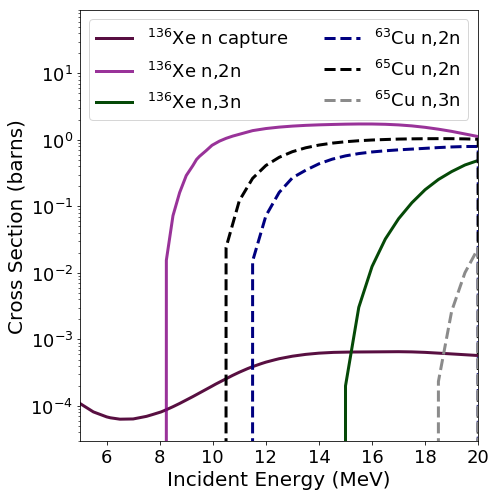

In [298]:
plt.figure(figsize=(7,7))

plt.plot(xe136cross[0],xe136cross[1],label="$^{136}$Xe n capture",color='xkcd:plum',lw=3)
plt.plot(n2n[0],n2n[1],label="$^{136}$Xe n,2n",color='purple',alpha=.8,lw=3)
plt.plot(n3n[0],n3n[1],label="$^{136}$Xe n,3n",color='xkcd:darkgreen',lw=3)
plt.plot(Cu63n2n[0],Cu63n2n[1],label='$^{63}$Cu n,2n', color='navy',linestyle='--',lw=3)
plt.plot(Cu65n2n[0],Cu65n2n[1],label='$^{65}$Cu n,2n', color='xkcd:black',linestyle='--',lw=3)
plt.plot(Cu65n3n[0],Cu65n3n[1],label='$^{65}$Cu n,3n', color='117',linestyle='--',lw=3)
plt.semilogy()
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
plt.ylim(3e-5,9e1)  
plt.xlim(5,20)
plt.ylabel("Cross Section (barns)",fontsize=20)
plt.xlabel('Incident Energy (MeV)',fontsize=20)
plt.tight_layout()
plt.legend(fontsize=18,loc='upper left',ncol=2)
plt.savefig('neutroncrosssections.png',dpi=250,bbox_inches='tight')
plt.show()

In [25]:
locat='/users/rogerslc/Google Drive/He3Studies/checkingneutrons/'
files =locat+'combinedfrom5378000muons.h5'
stuff=pd.read_hdf(files)  

(0.002, 900000)

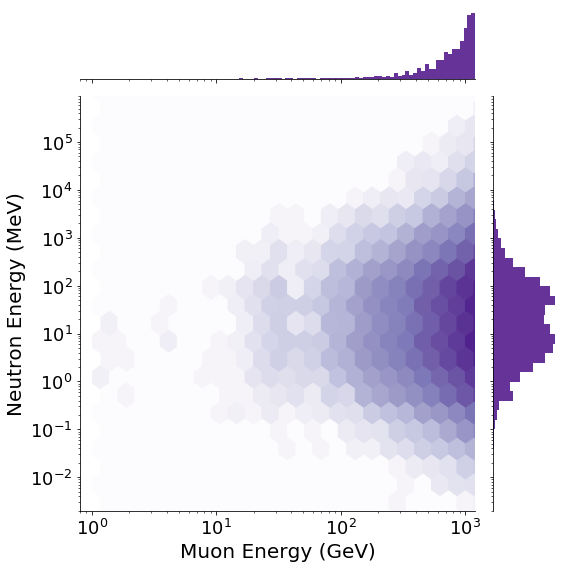

In [26]:
figsize=(8,8)

X=stuff[stuff.initvol=='WATER'].muonnrg*10**-3
Y=stuff[stuff.initvol=='WATER'].neutronnrg

nbins = 25

g = sns.JointGrid(X, Y, space=0,height=8)
g = g.plot_joint(plt.hexbin, gridsize=nbins,bins='log',xscale='log',yscale='log',cmap='Purples')
_ = g.ax_marg_y.hist(Y, color="rebeccapurple",
                      orientation="horizontal",
                      bins=np.logspace(np.log10(10**-2),np.log10(6*10**5),40))
_ = g.ax_marg_x.hist(X, color="rebeccapurple",
                      bins=np.logspace(np.log10(1),np.log10(1200),100))
g.set_axis_labels('Muon Energy (GeV)', 'Neutron Energy (MeV)', fontsize=20)




plt.tight_layout()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.xlim(8*10**-1,1200)
plt.ylim(2*10**-3,9*10**5)
#plt.savefig(locat+'nuvsmu_inwater.png',dpi=250,bbox_inches='tight')

(0.002, 900000)

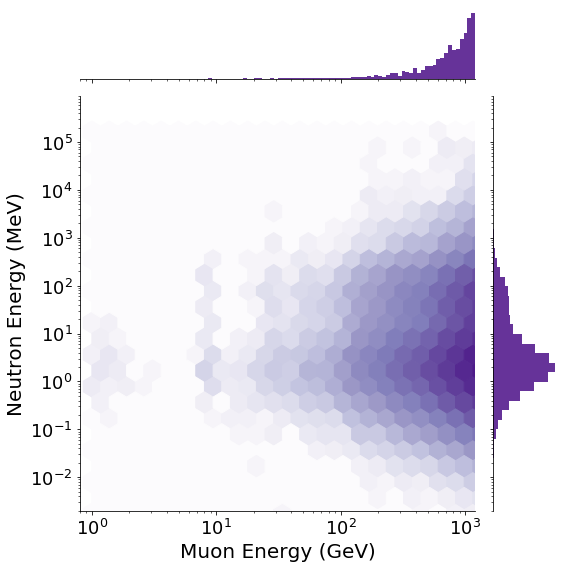

In [27]:
figsize=(8,8)

X=stuff[stuff.initvol!='WATER'].muonnrg*10**-3
Y=stuff[stuff.initvol!='WATER'].neutronnrg

nbins = 25

g = sns.JointGrid(X, Y, space=0,height=8)
g = g.plot_joint(plt.hexbin, gridsize=nbins,bins='log',xscale='log',yscale='log',cmap='Purples')
_ = g.ax_marg_y.hist(Y, color="rebeccapurple",
                      orientation="horizontal",
                      bins=np.logspace(np.log10(10**-2),np.log10(6*10**5),40))
_ = g.ax_marg_x.hist(X, color="rebeccapurple",
                      bins=np.logspace(np.log10(1),np.log10(1200),100))
g.set_axis_labels('Muon Energy (GeV)', 'Neutron Energy (MeV)', fontsize=20)




plt.tight_layout()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.xlim(8*10**-1,1200)
plt.ylim(2*10**-3,9*10**5)
#plt.savefig(locat+'nuvsmu_inwater.png',dpi=250,bbox_inches='tight')

In [28]:
nlocat='/Users/rogerslc/Google Drive/He3Studies/neutronNRGbeforeCapture/'
nfiles1000 =nlocat+'Xe137_counts_sim1000000neutrons_f0-100E1000.h5'
nfiles10000 =nlocat+'Xe137_counts_sim1000000neutrons_f0-100E10000.h5'
nfiles1000000 =nlocat+'Xe137_counts_sim1000000neutrons_f0-100E1000000.h5'
nNRG1000=pd.read_hdf(nfiles1000) 
nNRG1000000=pd.read_hdf(nfiles10000) 
nNRG1000000=pd.read_hdf(nfiles1000000)  

In [30]:
numberofnus=1000000
nmax=10.1
nbins=np.linspace(0,nmax,30)
nbin_centers = nbins[:-1] + np.diff(nbins) / 2
binned_Xe137n10000000data=plt.hist(nNRG10000000['XeMotherNrg'],nbins)
binned_Xe137n1000000data=plt.hist(nNRG1000000['XeMotherNrg'],nbins)
binned_Xe137n100000data=plt.hist(nNRG100000['XeMotherNrg'],nbins)
binned_Xe137n10000data=plt.hist(nNRG10000['XeMotherNrg'],nbins)
binned_Xe137n1000data=plt.hist(nNRG1000['XeMotherNrg'],nbins)

NameError: name 'nNRG10000000' is not defined

In [ ]:
numberofnus=1000000
fig = plt.figure(figsize=(7,7))
nmax=10.1
nbins=np.linspace(0,nmax,30)
nbin_centers = nbins[:-1] + np.diff(nbins) / 2

plt.scatter(nbin_centers, binned_Xe137n1000data[0],label="0.001 MeV",marker='^')
plt.scatter(nbin_centers, binned_Xe137n10000data[0],label="0.1 MeV",marker='^')
plt.scatter(nbin_centers, binned_Xe137n100000data[0],label="0.1 MeV",marker='^')
plt.scatter(nbin_centers, binned_Xe137n1000000data[0],label="1 MeV",marker='^')
plt.scatter(nbin_centers, binned_Xe137n10000000data[0],label="10 MeV",marker='^')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.legend(fontsize=18,loc=1, title="Starting Neutron Energy",title_fontsize=18, ncol=2)

plt.xlabel('Energy (MeV)',fontsize=20)

In [ ]:
len(nbin_centers)

In [ ]:
Xe137kenp=np.sqrt(nNRG1000000['Xe137kinE']**2)

In [ ]:
fig = plt.figure(figsize=(7,7))
plt.scatter(Xe137kenp,nNRG1000000['XeMotherNrg'])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
#plt.semilogx()
plt.ylabel('Energy of captured neutron energy',fontsize=20)
plt.xlabel('Energy of Xe137 (MeV)',fontsize=20)

In [ ]:
sum(Xe137kenp>=.001)

In [ ]:
np.sum(Xe137kenp<.001)